### This notebook is the benchmark notebook, where test results of each test notebook is combined together

In [ ]:
def plot_results(benchmark,normalize = True):
    if normalize:
        benchmark_norm = benchmark.iloc[:,2:-3].div(benchmark.sum(axis=1), axis=0)
        key = 'Normalized'
    else:
        benchmark_norm = benchmark.iloc[:,2:-3]
        key = 'Un-Normalized'
    plt.figure()
    y = np.arange(len(benchmark_norm.columns))
    col_labels = np.array(benchmark_norm.columns)
    for i in range(len(benchmark)):
        y_pos = y + i * (1/(2*len(col_labels)))
        plt.barh(y_pos,benchmark_norm.iloc[i,:],height = 1/(2*len(col_labels)),label = benchmark['Data_Type'][i] +  benchmark['Explainer_Type'][i][:3] +benchmark['Model_Type'][i][:3])
    plt.yticks([r + (1/(len(col_labels))) for r in range(len(y))], col_labels)
    plt.legend()
    plt.title(key + ' test errors in different datasets vs. method used (Trained over {0} via explainer {1} & model {2})'.format(benchmark.iloc[0,-3],benchmark.iloc[0,-2],benchmark.iloc[0,-1]))

In [ ]:
from os import listdir
#%run "Shapley_Clustering_Boston_Dataset.ipynb"
#%run "Shapley_Clustering_Crime_Dataset.ipynb"

for c in [0,3,4,6,7]:
    for nC in [2,4]:
        for i in ['Original']:
            for j in ['Linear']:
                for k in ['XGBoost']:
                    !python Shapley_Clustering_Blackbox.py $i $j $k $nC $c

In [ ]:
import shap
for i in range(1,2):
    !python Shapley_Clustering_Blackbox.py Original XGBoost XGBoost 3 $i

In [ ]:
for i in range(1,2):
    !python ../Framework/custom_sklearn_pipeline.py Original XGBoost XGBoost 3 $i

In [ ]:
for c in range(10):
    for nC in [3,5]:
        for i in ['Original-PCA','Shapley-PCA']:
            for j in ['Linear','XGBoost']:
                for k in ['XGBoost']:
                    !python Shapley_Clustering_PCA_Blackbox.py $i $j $k $nC $c

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
benchmark_df = pd.read_csv('../Data/experiment_combined.txt')

In [28]:
bsl1 = benchmark_df.groupby('Dataset_name').agg({'Explainer_model' : min})
bsl2 = benchmark_df.groupby('Dataset_name').agg({'Original_ensemble' : min})
bsl1

,Explainer_model
Dataset_name,
Admissions,0.447
Amazon,0.927
Boston,0.545
Crime,0.652
Diabetes,0.743
Fish_weights,0.171
Insurance,0.471
NYE_Airbnb,0.832
Nhanes,0.804


In [29]:
bsl2

,Original_ensemble
Dataset_name,
Admissions,0.468
Amazon,0.906
Boston,0.497
Crime,0.646
Diabetes,0.743
Fish_weights,0.171
Insurance,0.326
NYE_Airbnb,0.809
Nhanes,0.804


In [30]:
for j in range(len(benchmark_df['Dataset_name'])):
    benchmark_df['Explainer_model'].iloc[j] = bsl1.loc[benchmark_df['Dataset_name'].iloc[j]][0]
    benchmark_df['Original_ensemble'].iloc[j] = bsl2.loc[benchmark_df['Dataset_name'].iloc[j]][0]

C:\Users\koral\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [31]:
#benchmark_df_min = benchmark_df[(benchmark_df['Explainer_model'] > benchmark_df['Shapley_ensemble']) & (benchmark_df['Original_ensemble'] > benchmark_df['Shapley_ensemble'])]
benchmark_df_min = benchmark_df
bsl1_improvement = (benchmark_df_min['Explainer_model'] - benchmark_df_min['Shapley_ensemble']).divide(benchmark_df_min['Explainer_model'])
bsl2_improvement = (benchmark_df_min['Original_ensemble'] - benchmark_df_min['Shapley_ensemble']).divide(benchmark_df_min['Original_ensemble'])
benchmark_df_min['Percentage_Improvement'] = round(100 * (bsl1_improvement+bsl2_improvement)/2,1)
benchmark_df_min = benchmark_df_min.loc[benchmark_df_min['Percentage_Improvement'] > 0]
benchmark_df_min

,Dataset_name,Explainer_model,Original_ensemble,Shapley_ensemble,Cluster_count,Data_Type,Explainer_Type,Ensemble_model_Type,Percentage_Improvement
8,Amazon,0.927,0.906,0.905,3,Original,XGBoost,XGBoost,1.2
10,Amazon,0.927,0.906,0.887,3,Original,Linear,XGBoost,3.2
14,Amazon,0.927,0.906,0.887,3,Shapley,Linear,XGBoost,3.2
16,Amazon,0.927,0.906,0.899,5,Original,XGBoost,XGBoost,1.9
18,Amazon,0.927,0.906,0.891,5,Original,Linear,XGBoost,2.8
20,Amazon,0.927,0.906,0.914,5,Shapley,XGBoost,XGBoost,0.3
22,Amazon,0.927,0.906,0.891,5,Shapley,Linear,XGBoost,2.8
32,Boston,0.545,0.497,0.476,3,Original,XGBoost,XGBoost,8.4
36,Boston,0.545,0.497,0.420,3,Shapley,XGBoost,XGBoost,19.2
37,Boston,0.545,0.497,0.424,3,Shapley,XGBoost,Linear,18.4


In [32]:
bench_datatype_grouped = benchmark_df_min.groupby('Data_Type').agg({'Percentage_Improvement':np.mean})
bench_dataset_grouped = benchmark_df_min.groupby(['Dataset_name']).agg({'Percentage_Improvement':np.mean, 'Data_Type':'nunique'})
bench_dataset_grouped = bench_dataset_grouped[bench_dataset_grouped['Data_Type'] == 1]
benchmark_df_min = benchmark_df_min[benchmark_df_min['Dataset_name'] != 'NYE_Airbnb']
bench_datatype_grouped = benchmark_df_min.groupby(['Data_Type','Dataset_name']).agg({'Percentage_Improvement':np.mean})
bench_dataset_grouped = benchmark_df_min.groupby(['Dataset_name','Data_Type']).agg({'Percentage_Improvement':np.mean})
bench_datatype_grouped = bench_datatype_grouped.groupby('Data_Type').mean()
bench_dataset_grouped

Percentage_Improvement
Dataset_name   Data_Type                           
Admissions     Original                    0.366667
Amazon         Original                    2.016667
               Shapley                     2.100000
Boston         Original                   14.066667
               Shapley                    17.460000
Crime          Original                    0.800000
               Shapley                     0.500000
Diabetes       Original                    0.500000
               Shapley                     1.750000
Fish_weights   Original                    2.300000
               Shapley                     2.300000
Insurance      Original                   10.933333
               Original-PCA               12.325000
               Shapley                    11.362500
Student_grades Original                    6.700000
               Original-PCA                2.400000
               Shapley                     3.371429
               Shapley-PCA                 3.200000

Text(0.5, 1.0, 'Percentage improvement over all methods and datasets for given feature space')

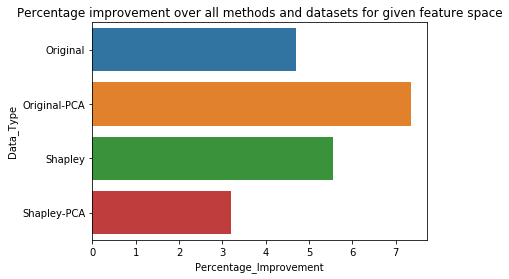

In [33]:
g = sns.barplot(y =bench_datatype_grouped.index ,x ='Percentage_Improvement',data = bench_datatype_grouped)
g.set_title ('Percentage improvement over all methods and datasets for given feature space')

Text(0.5, 1.0, 'Percentage improvement in rmse over all models for given dataset')

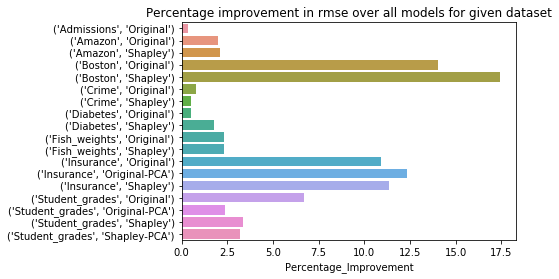

In [34]:
g= sns.barplot(y =bench_dataset_grouped.index ,x ='Percentage_Improvement',data = bench_dataset_grouped)
g.set_title('Percentage improvement in rmse over all models for given dataset')

In [35]:
data_min = benchmark_df_min.groupby(['Data_Type','Explainer_Type','Ensemble_model_Type']).agg({'Dataset_name':'nunique','Percentage_Improvement':np.mean})
data_min['Percentage_Improvement'] = round(data_min['Percentage_Improvement'],1)
data_min.columns = ['Dataset_count','Percentage_Improvement']
best_params = data_min['Dataset_count'].idxmax()

In [36]:
data_min

Dataset_count  \
Data_Type    Explainer_Type Ensemble_model_Type                  
Original     Linear         Linear                           2   
                            XGBoost                          7   
             XGBoost        Linear                           1   
                            XGBoost                          6   
Original-PCA Linear         XGBoost                          1   
             XGBoost        XGBoost                          2   
Shapley      Linear         Linear                           2   
                            XGBoost                          5   
             XGBoost        Linear                           3   
                            XGBoost                          6   
Shapley-PCA  Linear         XGBoost                          1   

                                                 Percentage_Improvement  
Data_Type    Explainer_Type Ensemble_model_Type                          
Original     Linear         Linear                                  5.4  
                            XGBoost                                 9.2  
             XGBoost        Linear                                  4.9  
                            XGBoost                                 5.5  
Original-PCA Linear         XGBoost                                12.5  
             XGBoost        XGBoost                                 8.9  
Shapley      Linear         Linear                                  5.4  
                            XGBoost                                 8.8  
             XGBoost        Linear                                 11.1  
                            XGBoost                                 6.1  
Shapley-PCA  Linear         XGBoost                                 3.2

In [37]:
params_grouped = benchmark_df_min.groupby(['Data_Type','Explainer_Type','Ensemble_model_Type','Dataset_name'])
params_grouped_df = params_grouped.agg({'Explainer_model' : min ,'Original_ensemble':min, 'Shapley_ensemble' : min,'Percentage_Improvement':np.mean})
best_params_results = params_grouped_df.loc[best_params]

In [38]:
list(best_params)

['Original', 'Linear', 'XGBoost']

In [39]:
#sets = benchmark_df[(benchmark_df.Data_Type == best_params[0]) & (benchmark_df.Explainer_Type == best_params[1]) & (benchmark_df.Ensemble_model_Type == best_params[2])]
#sets

In [40]:
best_params_results

,Explainer_model,Original_ensemble,Shapley_ensemble,Percentage_Improvement
Dataset_name,,,,
Admissions,0.447,0.468,0.455,0.500
Amazon,0.927,0.906,0.887,3.000
Boston,0.545,0.497,0.384,26.100
Crime,0.652,0.646,0.644,0.800
Fish_weights,0.171,0.171,0.167,2.300
Insurance,0.471,0.326,0.326,14.375
Student_grades,0.495,0.495,0.457,7.700


Text(0.5, 1.0, 'Percentage improvement in rmse for Feature Space: Original /Explainer(M_e): Linear /Leaf_Model(M_c1): XGBoost')

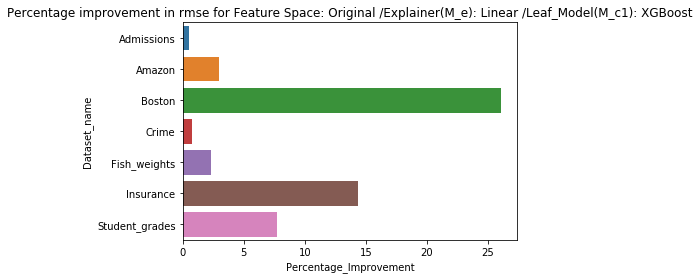

In [41]:
g = sns.barplot(y =best_params_results.index ,x ='Percentage_Improvement',data = best_params_results)
g.set_title('Percentage improvement in rmse for Feature Space: {0} /Explainer(M_e): {1} /Leaf_Model(M_c1): {2}'.format(best_params[0],best_params[1],best_params[2]))

In [ ]:
data_min = benchmark_df.groupby(['Data_Type','Explainer_Type','Ensemble_model_Type','Dataset_name'])
data_min_df = data_min.agg({'Explainer_model' : min ,'Original_ensemble':min, 'Shapley_ensemble' : min})
data_real_min = data_min_df[(data_min_df['Explainer_model'] > data_min_df['Shapley_ensemble']) & (data_min_df['Original_ensemble'] > data_min_df['Shapley_ensemble'])]
bsl1_improvement = (data_real_min['Explainer_model'] - data_real_min['Shapley_ensemble']).divide(data_real_min['Explainer_model'])
bsl2_improvement = (data_real_min['Original_ensemble'] - data_real_min['Shapley_ensemble']).divide(data_real_min['Original_ensemble'])
data_real_min['Avg_Percentage_Improvement'] = 100 * (bsl1_improvement+bsl2_improvement)/2
data_real_min

In [ ]:
data_min = benchmark_df.groupby(['Data_Type','Explainer_Type','Ensemble_model_Type','Dataset_name'])
data_min_df = data_min.agg({'Explainer_model' : min ,'Original_ensemble':min, 'Shapley_ensemble' : min})
data_real_min = data_min_df[(data_min_df['Explainer_model'] > data_min_df['Shapley_ensemble']) & (data_min_df['Original_ensemble'] > data_min_df['Shapley_ensemble'])]
bsl1_improvement = (data_real_min['Explainer_model'] - data_real_min['Shapley_ensemble']).divide(data_real_min['Explainer_model'])
bsl2_improvement = (data_real_min['Original_ensemble'] - data_real_min['Shapley_ensemble']).divide(data_real_min['Original_ensemble'])
data_real_min['Avg_Percentage_Improvement'] = 100 * (bsl1_improvement+bsl2_improvement)/2
data_real_min

In [ ]:
data_real_min2 = data_real_min['Shapley_ensemble'].groupby(['Data_Type','Ensemble_model_Type','Explainer_Type']).count()
data_param_count = data_real_min2.groupby(['Data_Type','Explainer_Type','Ensemble_model_Type']).sum()
data_param_count

In [ ]:
data_min = benchmark_df.groupby(['Data_Type','Cluster_count','Explainer_Type','Ensemble_model_Type','Dataset_name'])
data_min_df = data_min.agg({'Explainer_model' : min ,'Original_ensemble':min, 'Shapley_ensemble' : min})
data_real_min = data_min_df[(data_min_df['Explainer_model'] > data_min_df['Shapley_ensemble']) & (data_min_df['Original_ensemble'] > data_min_df['Shapley_ensemble'])]
data_real_min

In [ ]:
data_real_min2 = data_real_min['Shapley_ensemble'].groupby(['Data_Type','Cluster_count','Ensemble_model_Type','Explainer_Type']).count()
data_param_count = data_real_min2.groupby(['Data_Type','Cluster_count','Explainer_Type','Ensemble_model_Type']).sum()
data_param_count

In [ ]:
benchmark_df = pd.read_csv('../Data/test_results_all_data.txt')
bsl1 = benchmark_df.groupby('Dataset_name').agg({'Explainer_model' : min})
bsl2 = benchmark_df.groupby('Dataset_name').agg({'Original_ensemble' : min})
for j in range(len(benchmark_df['Dataset_name'])):
    benchmark_df['Explainer_model'].iloc[j] = bsl1.loc[benchmark_df['Dataset_name'].iloc[j]][0]
    benchmark_df['Original_ensemble'].iloc[j] = bsl2.loc[benchmark_df['Dataset_name'].iloc[j]][0]
data_min = benchmark_df.groupby(['Data_Type','Explainer_Type','Ensemble_model_Type','Dataset_name'])
data_min_df = data_min.agg({'Explainer_model' : min ,'Original_ensemble':min, 'Shapley_ensemble' : min})
data_real_min = data_min_df[(data_min_df['Explainer_model'] > data_min_df['Shapley_ensemble']) & (data_min_df['Original_ensemble'] > data_min_df['Shapley_ensemble'])]
data_real_min

In [ ]:
data_real_min2 = data_real_min['Shapley_ensemble'].groupby(['Data_Type','Ensemble_model_Type','Explainer_Type']).count()
data_param_count = data_real_min2.groupby(['Data_Type','Explainer_Type','Ensemble_model_Type']).sum()
data_param_count

In [ ]:
data_min = benchmark_df.groupby(['Data_Type','Cluster_count','Explainer_Type','Ensemble_model_Type','Dataset_name'])
data_min_df = data_min.agg({'Explainer_model' : min ,'Original_ensemble':min, 'Shapley_ensemble' : min})
data_real_min = data_min_df[(data_min_df['Explainer_model'] > data_min_df['Shapley_ensemble']) & (data_min_df['Original_ensemble'] > data_min_df['Shapley_ensemble'])]
data_real_min

In [ ]:
data_real_min2 = data_real_min['Shapley_ensemble'].groupby(['Data_Type','Cluster_count','Ensemble_model_Type','Explainer_Type']).count()
data_param_count = data_real_min2.groupby(['Data_Type','Cluster_count','Explainer_Type','Ensemble_model_Type']).sum()
data_param_count

In [ ]:
benchmark_df_bst = benchmark_df_min[benchmark_df_min['Dataset_name'] == 'Amazon']
benchmark_df_org = benchmark_df_bst[(benchmark_df_bst['Data_Type'] == 'Original')]
benchmark_df_shap = benchmark_df_bst[(benchmark_df_bst['Data_Type'] == 'Shapley')]
benchmark_df_org.reset_index(inplace = True)
benchmark_df_shap.reset_index(inplace = True)

In [ ]:
benchmark_melted_org = pd.melt(benchmark_df_org.iloc[:,[2,3,4,5,7,8]] , id_vars = ['Explainer_Type','Ensemble_model_Type','Cluster_count'], value_vars= ['Explainer_model','Original_ensemble','Shapley_ensemble'])
#benchmark_melted_org.drop_duplicates(benchmark_melted_org.columns[[0,3,4]],inplace = True)
benchmark_melted_org.rename(columns = {'variable':'Model','value':'rmse'},inplace = True)
g= sns.catplot(x = 'Explainer_Type',y = 'rmse', hue = 'Model',col = 'Ensemble_model_Type',row = 'Cluster_count',kind = 'bar',data = benchmark_melted_org)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Test-rmse results for dataset: {0} with training via: {1}'.format(benchmark_df_org['Dataset_name'].iloc[0], benchmark_df_org['Data_Type'].iloc[0]), fontsize=16)

In [ ]:
benchmark_melted_shap = pd.melt(benchmark_df_shap.iloc[:,[2,3,4,5,7,8]] , id_vars = ['Explainer_Type','Ensemble_model_Type','Cluster_count'], value_vars= ['Explainer_model','Original_ensemble','Shapley_ensemble'])
#benchmark_melted_shap.drop_duplicates(benchmark_melted_shap.columns[[0,3,4]],inplace = True)
benchmark_melted_shap.rename(columns = {'variable':'Model','value':'rmse'},inplace = True)
g= sns.catplot(x = 'Explainer_Type',y = 'rmse', hue = 'Model',col = 'Ensemble_model_Type',row = 'Cluster_count',kind = 'bar',data = benchmark_melted_shap)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Test-rmse results for dataset: {0} with training via: {1}'.format(benchmark_df_shap['Dataset_name'].iloc[0], benchmark_df_shap['Data_Type'].iloc[0]), fontsize=16)

In [ ]:
print("{0:.2f}".format(3.54662))

In [ ]:
!pip install openml tpot h2o

In [ ]:
!pip install scipy --upgrade

In [42]:
import openml
from openml import datasets
from openml import tasks
from openml import runs
from openml import flows
from openml import extensions
openml.config.apikey = '7be8de439f25368679e0802040791d1f'

In [43]:
import sys
sys.path.append('..')
from Framework.custom_sklearn_pipeline import CustomPipelineModel

In [44]:
shapley_pipeline = CustomPipelineModel('Shapley','Linear','XGBoost',3)
shapley_pipeline.pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'Shapley-Blackbox', 'Shapley-Blackbox__ensemble_type', 'Shapley-Blackbox__explainer_type', 'Shapley-Blackbox__nClusters', 'Shapley-Blackbox__notebook_mode'])

In [45]:
sk_learn_ext = extensions.sklearn.SklearnExtension()
flow = sk_learn_ext.model_to_flow(shapley_pipeline.pipeline)
flow.components['Shapley-Blackbox'].description = 'Thesis work v0.1'
flow.components
task = tasks.get_task(52948)
run = runs.run_flow_on_task(flow,task)

OpenMLRunsExistError: One or more runs of this setup were already performed on the task.

In [ ]:
sk_learn_ext.obtain_parameter_values(flow,shapley_pipeline.pipeline)

In [ ]:
run

In [22]:
from sklearn import metrics
scores = run.get_metric_fn(metrics.mean_squared_error)

In [23]:
scores

array([ 8.79867536,  9.03097311, 14.46789172,  7.16684439, 11.98255269,
        9.28219723,  5.64705949, 11.62064952, 13.06205899,  9.79941809])

In [24]:
scores.min()

5.64705948567227

In [25]:
myrun = run.publish()

In [26]:
myrun

OpenML Run
Uploader Name: None
Metric.......: None
Run ID.......: 10437750
Run URL......: https://www.openml.org/r/10437750
Task ID......: 52948
Task Type....: None
Task URL.....: https://www.openml.org/t/52948
Flow ID......: 17538
Flow Name....: sklearn.pipeline.Pipeline(Shapley-Blackbox=Framework.custom_sklearn_pipeline.CustomPipelineModel)
Flow URL.....: https://www.openml.org/f/17538
Setup ID.....: None
Setup String.: Python_3.7.1. Sklearn_0.20.1. NumPy_1.18.1. SciPy_1.4.1. Pipeline(memory=None,
     steps=[('Shapley-Blackbox', CustomPipelineModel(ensemble_type='XGBoost', explainer_type='Linear',
          nClusters=3, notebook_mode='Shapley'))])
Dataset ID...: 8
Dataset URL..: https://www.openml.org/d/8